**Mounting my google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Training**


## **Install Dependencies**

In [2]:
pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import cv2
from tf_explain.core.grad_cam import GradCAM

## **Load Model**

In [4]:
# Import the Desired Version of EfficientNet
from tensorflow.keras.applications import EfficientNetB0

## **Load Dataset**

1.   Load Dataset
2.   Initialize Train, Validtion & Test Set
3.   Set Augmentation Parameters



**Loading the WCE BLEED GEN dataset from Roboflow where I uploaded it for easy access and split the dataset as 80% Train and 20% Test.**

In [13]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="cKn8EJuXFYdKbWUJpIjO")
project = rf.workspace("team-scgyk").project("wce_bleed_gen_cls")
dataset = project.version(4).download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to WCE_Bleed_Gen_cls-4 in folder:: 100%|██████████| 2470/2470 [00:00<00:00, 4689.07it/s]


In [14]:
# Variables
NUM_CLASSES = 2

train_path = "/content/WCE_Bleed_Gen_cls-4/train/"
valid_path = "/content/WCE_Bleed_Gen_cls-4/valid/"
test_path = "/content/test/"

epochs = 50

model_save_location = "/content/drive/MyDrive/WCEBLEEDGen/model_cls.h5"


img_augmentation = Sequential(
    [
        #preprocessing.RandomRotation(factor=0.15),
        #preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        #preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

## **Define Methods**

Function to preprocess images

In [15]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

Function to rebuild the model for Transfer Learning

In [16]:
def build_model(NUM_CLASSES):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)

    #Using the imported version of EfficientNet
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [17]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

Function to validate the model

In [18]:
def test_model(model, test_batches):
    # Testing the Model
    test_labels = test_batches.classes
    predictions = model.predict(test_batches, steps=len(test_batches), verbose=0)

    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels, average='weighted')
    recall = recall_score(test_labels, predicted_labels, average='weighted')
    f1 = f1_score(test_labels, predicted_labels, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Confusion Matrix:")

    # Create a confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    print(cm)

    # Plot the confusion matrix as an image
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


    return accuracy, precision, recall, f1, cm

Function to plot training history

In [19]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## **Train The Model**

In [20]:
if __name__ == "__main__":
    model = build_model(NUM_CLASSES)
    unfreeze_model(model)
    # Create a generator for the train dataset
    train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=train_path, target_size=(224,224), batch_size=10)
    # Create a generator for the validation dataset
    valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=valid_path, target_size=(224,224), batch_size=10)

    _ = model.fit(train_batches, epochs=epochs, validation_data=valid_batches, verbose=1)

16705208/16705208 [==============================] - 2s 0us/step
Found 1971 images belonging to 2 classes.
Found 491 images belonging to 2 classes.
Epoch 1/50
198/198 [==============================] - 28s 56ms/step - loss: 0.3202 - accuracy: 0.8686 - val_loss: 0.1947 - val_accuracy: 0.9267
Epoch 2/50
198/198 [==============================] - 7s 37ms/step - loss: 0.1569 - accuracy: 0.9396 - val_loss: 0.1128 - val_accuracy: 0.9633
Epoch 3/50
198/198 [==============================] - 8s 40ms/step - loss: 0.1097 - accuracy: 0.9619 - val_loss: 0.0504 - val_accuracy: 0.9756
Epoch 4/50
198/198 [==============================] - 7s 38ms/step - loss: 0.0894 - accuracy: 0.9640 - val_loss: 0.0380 - val_accuracy: 0.9857
Epoch 5/50
198/198 [==============================] - 9s 43ms/step - loss: 0.0616 - accuracy: 0.9767 - val_loss: 0.0342 - val_accuracy: 0.9919
Epoch 6/50
198/198 [==============================] - 7s 37ms/step - loss: 0.0563 - accuracy: 0.9787 - val_loss: 0.0453 - val_accuracy: 

In [21]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 img_augmentation (Sequenti  (None, None, None, None)     0         ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['img_augmentation[0][0]']    
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']

In [22]:
# Save the tensorflow Model
model.save(model_save_location)

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


## **Visualize Results**

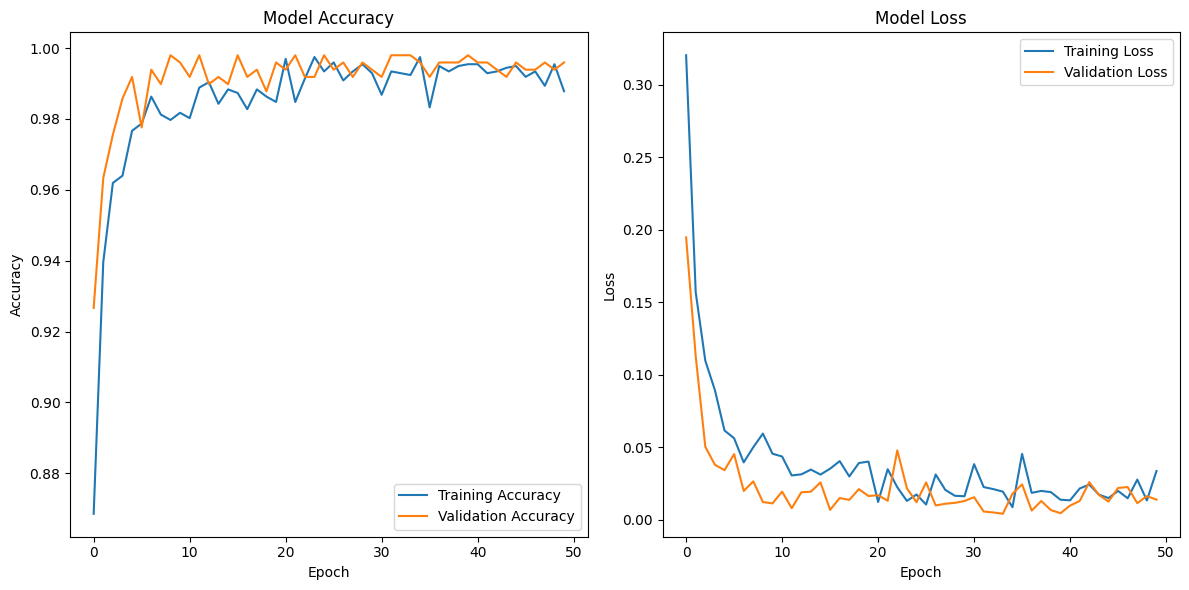

In [23]:
# After model training is complete, call plot_training_history
plot_training_history(_)

# **Validating the model**

In [25]:
# Load the .h5 model
modelx = tf.keras.models.load_model("/content/drive/MyDrive/WCEBLEEDGen/model_cls.h5")

# Define the path to your validation dataset
valid_path = "/content/WCE_Bleed_Gen_cls-4/valid"

# Create an ImageDataGenerator for preprocessing
valid_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

# Create a generator for the validation dataset
valid_batches = valid_datagen.flow_from_directory(
    directory=valid_path, target_size=(224, 224), batch_size=10, shuffle=False, class_mode=None
)

Found 491 images belonging to 2 classes.


Accuracy: 0.9959266802443992
Precision: 0.9959586278503254
Recall: 0.9959266802443992
F1-Score: 0.9959261050887808
Confusion Matrix:
[[253   0]
 [  2 236]]


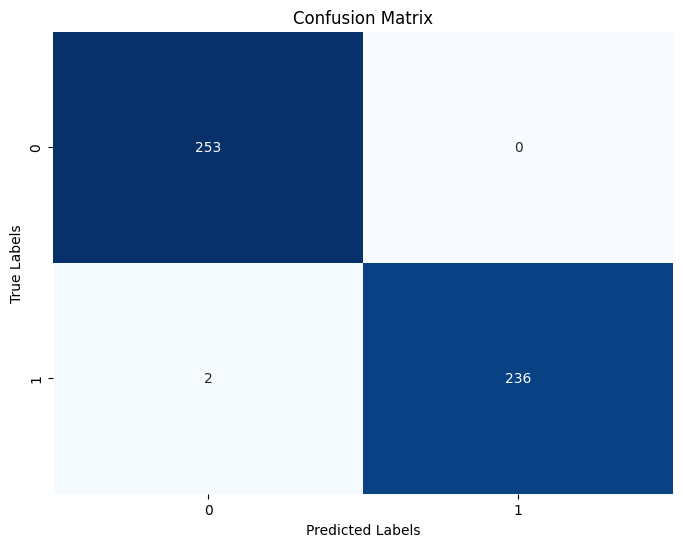

In [27]:
accuracy, precision, recall, f1, cm = test_model(modelx, valid_batches)